In [1]:
%load_ext autoreload
%autoreload 1
%matplotlib inline

import pdb

import matplotlib
matplotlib.rcParams['figure.figsize'] = [14, 10]

import torch
from torch.utils.data import Dataset
from retinanet.encoder import DataEncoder
import imgaug as ia
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
from retinanet.retinanet import RetinaNet
from retinanet.loss import FocalLoss
from pikachu_dataset import load_data_pikachu
from torch import nn
from torch.utils.data import Dataset
device  = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
class PikachuDataset(Dataset):
    
    def __init__(self, anchor_areas=None):
        self.anchor_areas = anchor_areas
        self.train, self.val = load_data_pikachu(1)
        if anchor_areas is not None:
            encoder = DataEncoder(anchor_areas=anchor_areas)
        else:
            encoder = DataEncoder()            
        self.encoder = encoder 
        
    def __len__(self):
        return 900
        
    def __getitem__(self, i):
        try:
            b = self.train.next()
        except StopIteration:
            self.train.reset()
            b = self.train.next()
        image = b.data[0].asnumpy()
        bbox = b.label[0].asnumpy()[:, 0, 1:] * 256
        label = b.label[0].asnumpy()[:, 0, 0]
        return torch.from_numpy(image), torch.from_numpy(bbox), torch.from_numpy(label)    
    
    def collate_func(self, batch):
        images = [b[0][0] for b in batch]
        bbox = [b[1] for b in batch]
        labels = [b[2] for b in batch]
        
        encoded = [self.encoder.encode(bb, l, torch.Tensor([256, 256])) for bb, l in zip(bbox, labels)]
        loc_target = [l[0] for l in encoded]
        cls_target = [l[1] for l in encoded]

        return torch.stack(images) / 255, torch.stack(loc_target), torch.stack(cls_target)
        
def down_sample(in_channels,out_channels):
    return nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1), 
                  nn.BatchNorm2d(out_channels), 
                  nn.ReLU(),
                 nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1), 
                  nn.BatchNorm2d(out_channels), 
                  nn.ReLU(),
                  nn.MaxPool2d(2,2)
                 )

class SimpleSSD(nn.Module):
    
    
    def __init__(self, n_cls=1, num_anchors=9):
        super(SimpleSSD, self).__init__()
        
        self.n_cls = n_cls
        self.num_anchors = num_anchors    
        
        # Base CNN (think resnet/vgg or other base network)
        self.step1 = down_sample(3, 128)
        self.step2 = down_sample(128, 128)
        
        self.step3 = down_sample(128, 128)
        self.step4 = down_sample(128, 128)
        self.step5 = down_sample(128, 128)

        # assumes one-hot encoded classes
        self.cls_head1 = nn.Conv2d(128, self.num_anchors * self.n_cls , 3, padding=1)
        self.bbox_head1 = nn.Conv2d(128, self.num_anchors *4, 3, padding=1)
        
        # assumes one-hot encoded classes
        self.cls_head2 = nn.Conv2d(128, self.num_anchors * self.n_cls , 3, padding=1)
        self.bbox_head2 = nn.Conv2d(128,self.num_anchors * 4,3, padding=1)
        
        # assumes one-hot encoded classes
        self.cls_head3 = nn.Conv2d(128, self.num_anchors * self.n_cls , 3, padding=1)
        self.bbox_head3 = nn.Conv2d(128, self.num_anchors * 4,3, padding=1) 
        
    def forward(self, x):
        
        step1=self.step1(x)
        step2=self.step2(step1)

        step3=self.step3(step2)
        step4 = self.step4(step3)
        step5 = self.step5(step4)    
        
        cls1 = self.cls_head1(step3)
        bbox1 = self.bbox_head1(step3)
        
        cls2 = self.cls_head2(step4)
        bbox2 = self.bbox_head2(step4)
        
        cls3 = self.cls_head3(step5)
        bbox3 = self.bbox_head3(step5)
        
        #pdb.set_trace()        
        
        # assumes one-hot encoded classes
        cls1 = cls1.permute(0,2,3,1).contiguous().view(x.size(0), -1, self.n_cls)
        cls2 = cls2.permute(0,2,3,1).contiguous().view(x.size(0), -1, self.n_cls)
        cls3 = cls3.permute(0,2,3,1).contiguous().view(x.size(0), -1, self.n_cls)
        
        bbox1 = bbox1.permute(0,2,3,1).contiguous().view(x.size(0), -1, 4)
        bbox2 = bbox2.permute(0,2,3,1).contiguous().view(x.size(0), -1, 4)
        bbox3 = bbox3.permute(0,2,3,1).contiguous().view(x.size(0), -1, 4)
      
        cls_pred = torch.cat([cls1, cls2, cls3], dim=1)
        bbox_pred = torch.cat([bbox1, bbox2, bbox3], dim=1)
        
        return bbox_pred, cls_pred

In [3]:
pikachu_ds =PikachuDataset(anchor_areas = [30*30, 50*50, 90*90])
pikachu_dl = DataLoader(pikachu_ds, batch_size = 2, collate_fn = pikachu_ds.collate_func)

In [4]:
model = SimpleSSD(1)
model = model.to(device)
criterion = FocalLoss(num_classes = 1)

In [5]:
# Basically: (Focal) loss between ALL (non-ignored) ground-truth anchor boxes (class and delta for (xy, dims) for every
# coordinate within all feature maps) and corresponding predicted feature maps
import time
tic = time.time()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
collect = []
for epoch in range(2):
    print(epoch)
    for b in pikachu_dl:
        optimizer.zero_grad()
        image, bounding_boxes, labels = b
        image = image.to(device)
        bounding_boxes = bounding_boxes.to(device)
        labels = labels.to(device)
        loc_pred, cls_pred = model(image)
        total_loss = criterion(loc_pred, bounding_boxes, cls_pred, labels)
        total_loss.backward()
        optimizer.step()
        collect.append([total_loss.detach().cpu().numpy()])
        
toc = time.time()
print(f'Done after = {toc-tic:.3f}s')

0
clsloss: 3337.4736328125 locloss: 60.61980438232422
clsloss: 3030.400390625 locloss: 23.092363357543945
clsloss: 2806.268310546875 locloss: 18.895017623901367


/opt/conda/envs/dsr/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


clsloss: 2561.63525390625 locloss: 20.869609832763672
clsloss: 2347.941650390625 locloss: 16.365074157714844
clsloss: 2224.9140625 locloss: 15.748308181762695
clsloss: 2053.99072265625 locloss: 8.307663917541504
clsloss: 1846.8359375 locloss: 19.812969207763672
clsloss: 1771.37060546875 locloss: 10.724112510681152
clsloss: 1609.129638671875 locloss: 10.464126586914062
clsloss: 1444.769287109375 locloss: 10.787572860717773
clsloss: 1334.0848388671875 locloss: 13.506689071655273
clsloss: 1278.7158203125 locloss: 9.653786659240723
clsloss: 1118.2005615234375 locloss: 7.008875370025635
clsloss: 1014.4923706054688 locloss: 9.220002174377441
clsloss: 1038.9814453125 locloss: 8.3635835647583
clsloss: 973.3883666992188 locloss: 9.430612564086914
clsloss: 871.3533325195312 locloss: 12.729654312133789
clsloss: 929.2359619140625 locloss: 11.926973342895508
clsloss: 722.8118896484375 locloss: 8.953631401062012
clsloss: 837.9325561523438 locloss: 8.64842700958252
clsloss: 658.6066284179688 locloss:

clsloss: 45.1357536315918 locloss: 4.278997898101807
clsloss: 41.20482635498047 locloss: 3.2118704319000244
clsloss: 51.66817092895508 locloss: 3.3164780139923096
clsloss: 46.755287170410156 locloss: 5.059126377105713
clsloss: 35.3065299987793 locloss: 3.106452703475952
clsloss: 28.486507415771484 locloss: 2.681222677230835
clsloss: 35.565128326416016 locloss: 6.454907417297363
clsloss: 31.628313064575195 locloss: 2.428194761276245
clsloss: 36.68171691894531 locloss: 5.89517879486084
clsloss: 31.210731506347656 locloss: 4.391122341156006
clsloss: 27.735294342041016 locloss: 3.946737051010132
clsloss: 28.539989471435547 locloss: 3.9007909297943115
clsloss: 30.318639755249023 locloss: 3.177278518676758
clsloss: 65.38444519042969 locloss: 3.688594341278076
clsloss: 24.944652557373047 locloss: 3.033698081970215
clsloss: 30.47161293029785 locloss: 5.037721633911133
clsloss: 32.33867645263672 locloss: 2.893472909927368
clsloss: 32.047515869140625 locloss: 5.560337066650391
clsloss: 72.072273

clsloss: 46.98138427734375 locloss: 2.5686631202697754
clsloss: 22.718097686767578 locloss: 6.0586256980896
clsloss: 23.44559097290039 locloss: 3.0908923149108887
clsloss: 20.550540924072266 locloss: 3.542525291442871
clsloss: 41.68339538574219 locloss: 4.152920246124268
clsloss: 19.593948364257812 locloss: 2.717987060546875
clsloss: 18.38860321044922 locloss: 2.9285707473754883
clsloss: 20.2856388092041 locloss: 2.8712265491485596
clsloss: 17.910663604736328 locloss: 2.424549102783203
clsloss: 24.009151458740234 locloss: 3.8368453979492188
clsloss: 19.068744659423828 locloss: 3.2672388553619385
clsloss: 32.95660400390625 locloss: 5.759397506713867
clsloss: 25.134065628051758 locloss: 5.0926713943481445
clsloss: 28.623628616333008 locloss: 3.0996251106262207
clsloss: 16.578441619873047 locloss: 2.869296073913574
clsloss: 23.09337043762207 locloss: 1.988671064376831
clsloss: 17.909975051879883 locloss: 4.102614879608154
clsloss: 25.893531799316406 locloss: 5.0021514892578125
clsloss: 19

clsloss: 15.17839241027832 locloss: 2.235924005508423
clsloss: 14.01291275024414 locloss: 2.422680139541626
clsloss: 12.288274765014648 locloss: 2.0092570781707764
clsloss: 15.629207611083984 locloss: 2.0993621349334717
clsloss: 12.51727294921875 locloss: 2.9952340126037598
clsloss: 15.387252807617188 locloss: 2.459840774536133
clsloss: 12.9324312210083 locloss: 2.8941597938537598
clsloss: 15.801763534545898 locloss: 3.0122568607330322
clsloss: 17.22167205810547 locloss: 1.7858774662017822
clsloss: 23.21710968017578 locloss: 1.7439708709716797
clsloss: 10.72541618347168 locloss: 2.355921745300293
clsloss: 14.960320472717285 locloss: 3.110384225845337
clsloss: 12.789352416992188 locloss: 1.9490900039672852
clsloss: 15.773258209228516 locloss: 3.304638385772705
clsloss: 20.648353576660156 locloss: 1.710724949836731
clsloss: 15.366791725158691 locloss: 3.8043406009674072
clsloss: 20.660287857055664 locloss: 2.145650625228882
clsloss: 21.214757919311523 locloss: 3.8814806938171387
clsloss:

clsloss: 12.036700248718262 locloss: 2.4919676780700684
clsloss: 12.250073432922363 locloss: 2.0958876609802246
clsloss: 13.121086120605469 locloss: 2.754687786102295
clsloss: 9.428112030029297 locloss: 1.5529289245605469
clsloss: 17.017662048339844 locloss: 1.928269624710083
clsloss: 12.257328033447266 locloss: 2.8858189582824707
clsloss: 12.468461036682129 locloss: 2.970187187194824
clsloss: 17.238346099853516 locloss: 2.4702389240264893
clsloss: 13.66472339630127 locloss: 2.9786980152130127
clsloss: 14.080198287963867 locloss: 2.963186025619507
clsloss: 12.236637115478516 locloss: 2.4726479053497314
clsloss: 15.913155555725098 locloss: 2.8791770935058594
clsloss: 11.116904258728027 locloss: 1.9462615251541138
clsloss: 9.9757080078125 locloss: 1.4189156293869019
clsloss: 15.09320068359375 locloss: 1.889889121055603
clsloss: 15.586469650268555 locloss: 3.047921657562256
clsloss: 12.209454536437988 locloss: 1.70815908908844
clsloss: 18.099517822265625 locloss: 2.700352668762207
clsloss

clsloss: 8.420143127441406 locloss: 1.6045265197753906
clsloss: 14.958561897277832 locloss: 1.8176220655441284
clsloss: 12.927480697631836 locloss: 1.1381675004959106
clsloss: 11.741443634033203 locloss: 1.7735040187835693
clsloss: 10.43531608581543 locloss: 2.1978065967559814
clsloss: 9.64095687866211 locloss: 1.7124426364898682
clsloss: 12.304237365722656 locloss: 2.3717565536499023
clsloss: 9.872014999389648 locloss: 2.4820687770843506
clsloss: 9.477091789245605 locloss: 1.7575103044509888
clsloss: 18.6633358001709 locloss: 3.1007347106933594
clsloss: 10.968189239501953 locloss: 1.586432695388794
clsloss: 9.193609237670898 locloss: 1.5364596843719482
clsloss: 12.16473388671875 locloss: 2.6304619312286377
clsloss: 10.025496482849121 locloss: 1.8532475233078003
clsloss: 11.449810028076172 locloss: 2.40622878074646
clsloss: 12.062217712402344 locloss: 2.361154556274414
clsloss: 16.489730834960938 locloss: 1.7627744674682617
clsloss: 8.67605972290039 locloss: 1.1265602111816406
clsloss:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fec001a19b0>],
      dtype=object)

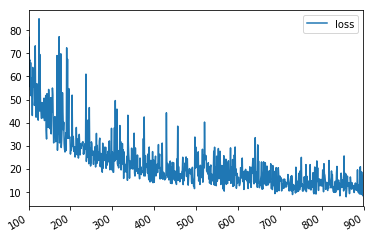

In [6]:
import pandas as pd
pd.DataFrame(collect, columns=['loss']).astype(float)[100:].plot(subplots=True)

# Visualize

In [7]:
it = iter(pikachu_dl)

Text(0.5, 1.0, 'score tensor([0.3922, 0.3922, 0.3657, 0.3657, 0.3429, 0.3429, 0.3162, 0.3162, 0.3061,\n        0.3061], grad_fn=<IndexBackward>)')

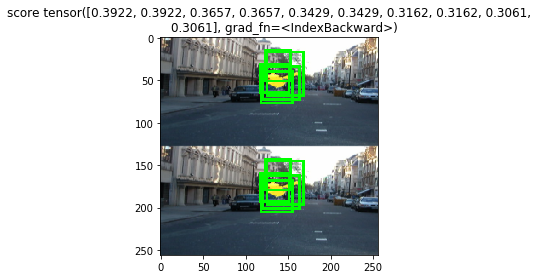

In [8]:
from torchvision.transforms import Resize, ToPILImage, ToTensor

b = next(it)

im = ToTensor()(Resize((256, 256))(ToPILImage()(torch.cat([b[0][0], b[0][0]], dim=1))))
image = im.unsqueeze(0)

enc = DataEncoder(anchor_areas=[30*30, 50*50, 90*90])
loc_pred, cls_pred = model(image.cuda())

i = 0
bbspred, labelpred, score  = enc.decode(
    loc_pred[i].float().cpu(), 
    cls_pred[i].float().cpu(), 
    torch.Tensor([256, 256]).float().cpu()
)

image_to_show = np.moveaxis(
    image[i].detach().cpu().numpy(),0, 2)

matched_anchors_on_image = ia.BoundingBoxesOnImage(
    [ia.BoundingBox(*b) for b in bbspred.detach().cpu().numpy()], shape=(256, 256))

image_to_show = matched_anchors_on_image.draw_on_image(image_to_show, thickness=3)
plt.imshow(image_to_show)
plt.title('score ' + str(score))

### Exercises

-  Load a custom image with pikachu( or many ) and try to make predictiosn with the network and visualize the result
-  Can you think of anything that could confuse our detector? yellow dots ?
- Currently the code is not really modular, try to make it nice by splitting it into logical parts
    - Base feature extractor Module
    - Head Creator module
- Currently the detection/cls HEADS are very simple (just one CONV layer) they can be more complex. Try using more convolutions, check other architectures how its done

- Can you use our network to train using some new data for instance:
    - https://www.kaggle.com/tomluther/ships-in-google-earth
    - https://www.kaggle.com/aruchomu/data-for-yolo-v3-kernel
    - https://www.kaggle.com/dataturks/face-detection-in-images
    - https://www.kaggle.com/dataturks/face-dataset-with-age-emotion-ethnicity  
 You will need to create a data loader/data sets similar as we did for the pikachu loader. 


Original image size = (341, 256)
Resized image size = (341, 256)
Cropped image size = (256, 256)
Tensor size = torch.Size([1, 3, 256, 256])


Text(0.5, 1.0, 'score tensor([0.3308, 0.3094], grad_fn=<IndexBackward>)')

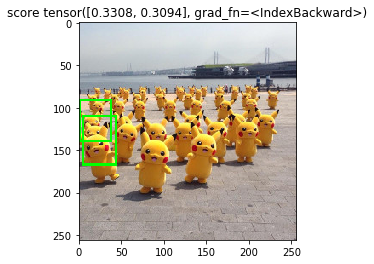

In [53]:
from PIL import Image
from random import randint
test_image = Image.open("Pikachus2.jpg").convert("RGB")
print(f'Original image size = {test_image.size}')
if (np.array(test_image.size) < 256).any():
    resizing_factor = 256 / (test_image.size[np.argmin(np.array(test_image.size))])
    test_image = test_image.resize(
        (int(np.ceil(test_image.size[0] * resizing_factor)), int(np.ceil(test_image.size[1] * resizing_factor))), 
        Image.ANTIALIAS)
print(f'Resized image size = {test_image.size}')
top_crop    = randint(0, test_image.size[0] - 255)
left_crop   = randint(0, test_image.size[1] - 255)
bottom_crop = top_crop + 256
right_crop  = left_crop + 256
test_image = test_image.crop((top_crop, left_crop, bottom_crop, right_crop))
print(f'Cropped image size = {test_image.size}')
plt.imshow(test_image)
test_image = torch.Tensor(np.array(test_image) / 255)
test_image = test_image.permute(2,0,1).contiguous().unsqueeze(dim = 0).to(device)
print(f'Tensor size = {test_image.shape}')

enc = DataEncoder(anchor_areas=[30*30, 50*50, 90*90])
loc_pred, cls_pred = model(test_image)

bbspred, labelpred, score  = enc.decode(
    loc_pred[i].float().cpu(), 
    cls_pred[i].float().cpu(), 
    torch.Tensor([256, 256]).float().cpu()
)

image_to_show = np.moveaxis(
    test_image.squeeze().detach().cpu().numpy(),0, 2)

matched_anchors_on_image = ia.BoundingBoxesOnImage(
    [ia.BoundingBox(*b) for b in bbspred.detach().cpu().numpy()], shape=(256, 256))

image_to_show = matched_anchors_on_image.draw_on_image(image_to_show, thickness=3)
plt.imshow(image_to_show)
plt.title('score ' + str(score))

The detector seem to have problems with multiple Pikachus and seems to detect only one per image. Maybe it was only trained on images containing one Pikachu? However, everything similar in appearance to Pikachus could probably yield false positives. Occluded Pikachus may even be not properly detected as well.